# Message Spam Detection Project using NLP (classification)

In [65]:
# import libraries

#data anlysis
import pandas as pd
import numpy as np

# visual
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

# preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# 1. Problem statement

detect weather the message is spam or not 

# 2. Data

In [6]:
df = pd.read_csv('data/spam.csv', encoding='ISO-8859-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# 3. Features & 4. Evaluation

### EDA 

In [8]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [9]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
df.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [13]:
df.columns = ['label', 'message']
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [16]:
df.shape

(5572, 2)

In [17]:
print(df.isnull().sum())

label      0
message    0
dtype: int64


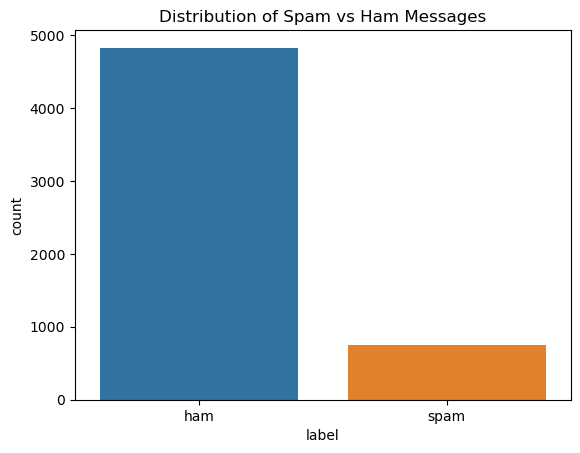

In [19]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')

plt.savefig("images/Distribution of Spam vs Ham Messages.png")
plt.show()

In [21]:
df['message_length'] = df['message'].apply(len)
df

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


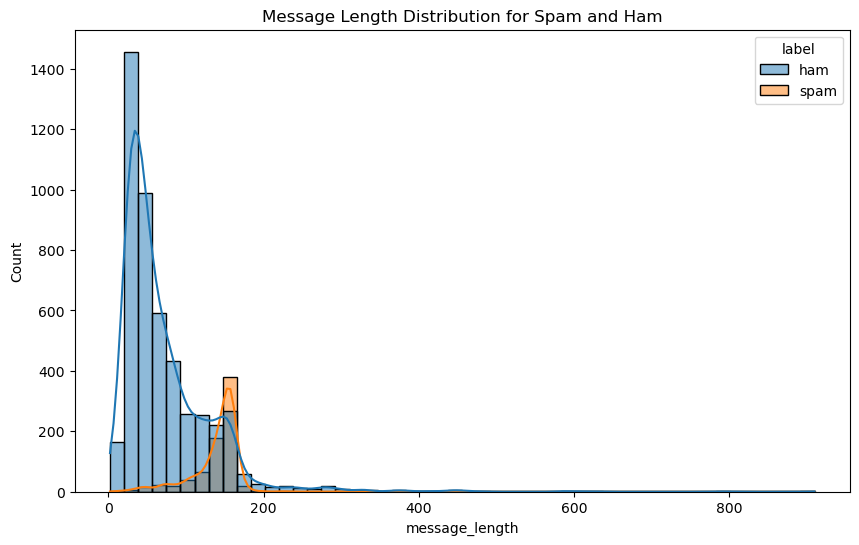

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title('Message Length Distribution for Spam and Ham')

plt.savefig("images/Message Length Distribution for Spam and Ham.png")
plt.show()

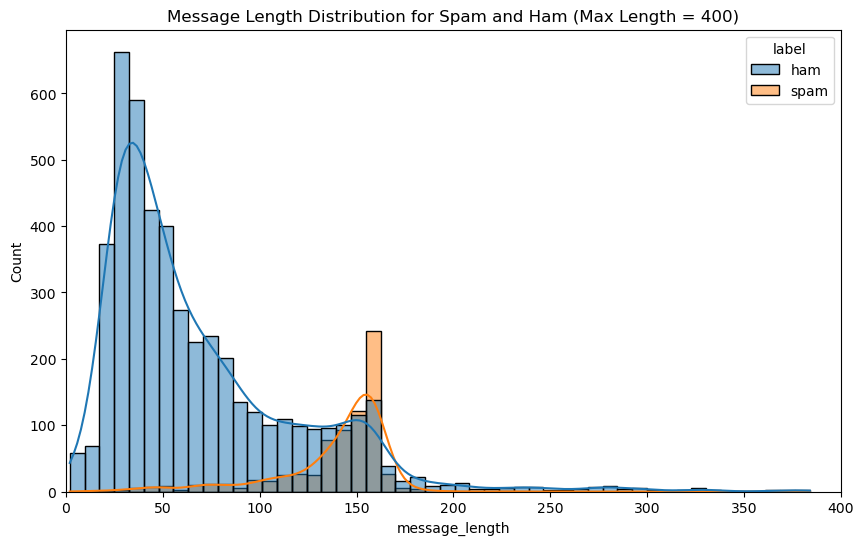

In [25]:
# Filter the DataFrame to only include messages with a length less than or equal to 400
df_filtered = df[df['message_length'] <= 400]

# Plot the histogram with the filtered data
plt.figure(figsize=(10,6))
sns.histplot(data=df_filtered, x='message_length', hue='label', bins=50, kde=True)
plt.title('Message Length Distribution for Spam and Ham (Max Length = 400)')
plt.xlim(0, 400)  # Set x-axis limit to 400
plt.savefig("images/Message Length Distribution for Spam and Ham(Max Length = 400).png")

plt.show()


In [27]:
df

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


### NLP

In [29]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sunrise\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sunrise\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
# 1. Text Preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to clean and preprocess the text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Stem
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the 'message' column
df['clean_message'] = df['message'].apply(preprocess_text)

In [31]:
df

,label,message,message_length,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah think goe usf live around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,2nd time tri 2 contact u pound prize 2 claim e...
5568,ham,Will Ì_ b going to esplanade fr home?,37,b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,piti mood suggest
5570,ham,The guy did some bitching but I acted like i'd...,125,guy bitch act like interest buy someth els nex...


### word net

In [33]:
# Using WordNet for Synonyms
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms



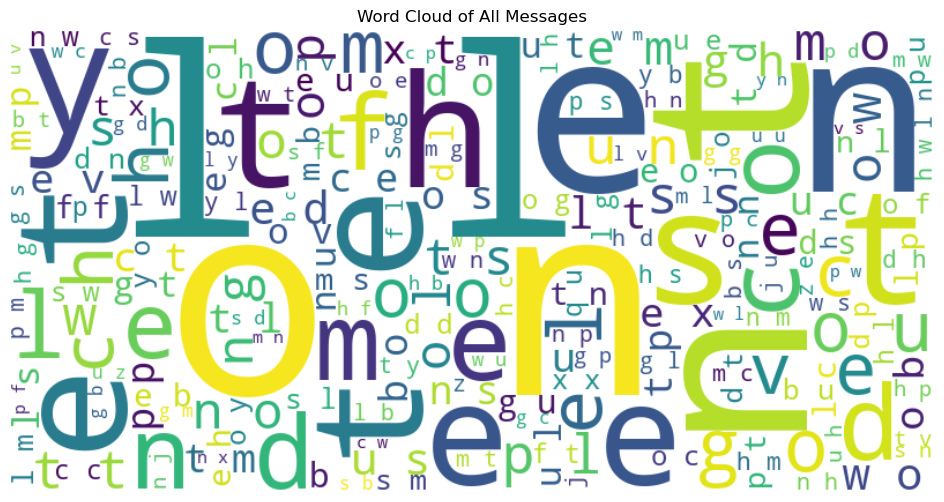

In [41]:
# Create a Word Cloud for all messages
all_text = ' '.join([word for sublist in df['clean_message'] for word in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Messages')

plt.savefig('images/Word Cloud of All Messages.png')
plt.show()


# 5. Modeling

### preprocessing

In [42]:
#  Convert labels from 'ham'/'spam' to 0/1
label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['label'])  # spam = 1, ham = 0

In [43]:
#  Feature Extraction
# Using TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)  # Adjust max_features as needed
X = tfidf.fit_transform(df['clean_message']).toarray()  # Feature matrix (tf-idf vectors)

In [44]:
#  Split the data into training and test sets
y = df['label_num']  # Target variable (spam = 1, ham = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Data is now ready for training a machine learning model
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (4457, 3000)
Test data shape: (1115, 3000)


### best Model

In [47]:
# Dictionary of Models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [48]:
# Train, Evaluate, and Score Each Model
scores = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    scores[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("="*50)

Model: Naive Bayes
Accuracy: 0.9776
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Model: Logistic Regression
Accuracy: 0.9462
Classification Report:
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       965
        spam       0.96      0.63      0.76       150

    accuracy                           0.95      1115
   macro avg       0.95      0.81      0.86      1115
weighted avg       0.95      0.95      0.94      1115

Model: SVM
Accuracy: 0.9731
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       0.98      0.81      0.89       150

    a

In [49]:
# Find the best model
best_model_name = max(scores, key=scores.get)
best_model_score = scores[best_model_name]
print(f"The best model is {best_model_name} with an accuracy of {best_model_score:.4f}")

The best model is Naive Bayes with an accuracy of 0.9776


### Naive bayes

In [52]:
# Train Naive Bayes Model
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute metrics
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

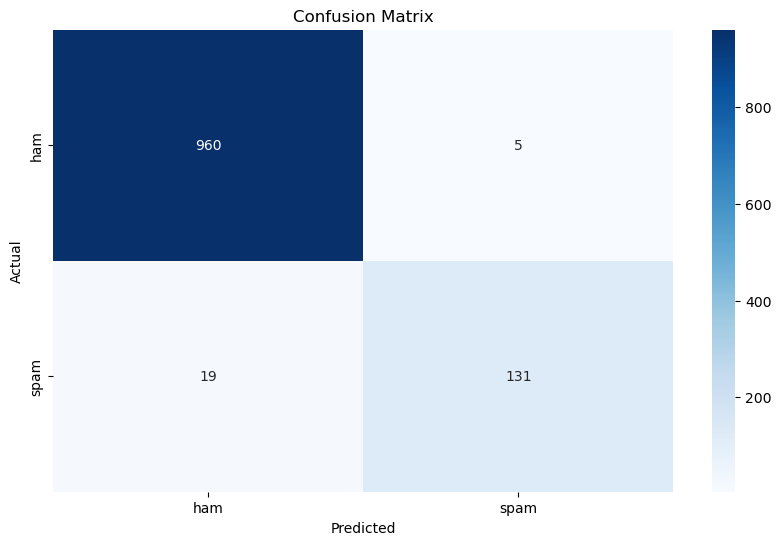

In [61]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig('images/Confusion Matrix.png')
plt.show()

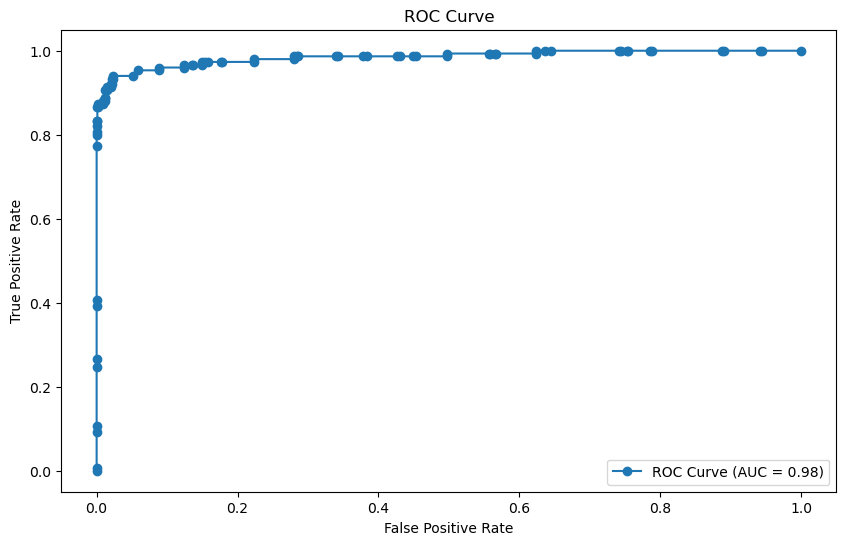

In [62]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='o', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig('images/ROC Curve.png')
plt.show()

In [57]:
# Additional metric visualizations
precision = report['spam']['precision']
recall = report['spam']['recall']
f1_score = report['spam']['f1-score']

# Print additional metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 1.0000
Recall: 0.8333
F1 Score: 0.9091


### hyper parameters tunning 

In [59]:
# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

# Initialize Grid Search
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report with Best Parameters:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score: 0.9825
Classification Report with Best Parameters:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.96      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Classification Report with Best Parameters:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.96      0.87      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



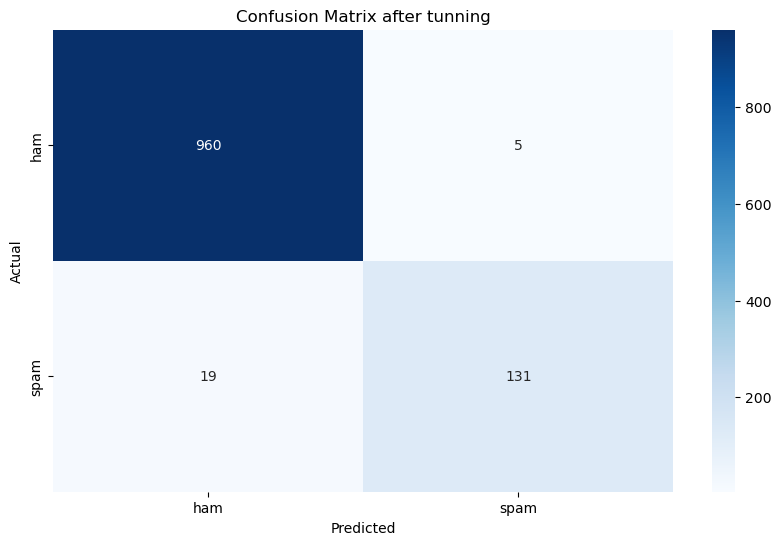

In [63]:
# Create the model with the best parameters
best_model = MultinomialNB(alpha=0.1, fit_prior=True)

# Train the model
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute metrics
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print classification report
print("Classification Report with Best Parameters:")
print(report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix after tunning')

plt.savefig('images/Confusion Matrix after tunning.png')
plt.show()

In [64]:
# Feature Extraction with N-grams
tfidf_ngram = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X_ngram = tfidf_ngram.fit_transform(df['clean_message']).toarray()

# Split the data into training and test sets
X_train_ngram, X_test_ngram, y_train, y_test = train_test_split(X_ngram, y, test_size=0.2, random_state=42)

# Train and evaluate Naive Bayes model with n-grams
model_ngram = MultinomialNB()
model_ngram.fit(X_train_ngram, y_train)

# Predict and evaluate
y_pred_ngram = model_ngram.predict(X_test_ngram)
y_proba_ngram = model_ngram.predict_proba(X_test_ngram)[:, 1]

print("Classification Report with N-grams:")
print(classification_report(y_test, y_pred_ngram, target_names=label_encoder.classes_))


Classification Report with N-grams:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       965
        spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [66]:
# Perform cross-validation
cv_scores = cross_val_score(MultinomialNB(alpha=1.0), X, y, cv=5, scoring='accuracy')

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")

Cross-Validation Scores: [0.9838565  0.97399103 0.97307002 0.97486535 0.97217235]
Mean Cross-Validation Score: 0.9756
